## Predict ribosomal genes with embeddings

We don't have embedings for yeast. Correction: we have embeddings of a proxy-species
We want to predict yeast gene "identity" based on UTR
We need get the embeddings for genes homologous to yeast genes. 

1. Get a positive set
    1. Filter the subject gene ids for ribosomal genes
    2. Get the most homologous and significant hits for these genes in one species
    3. Get the gene embeddings for these genes
2. Get a negative set
    1. Filter the subject ids for non-ribosomal genes
    2. see 1.
3. Train
4. Predict

In [1]:
import sys
if ".." not in sys.path: 
    sys.path.append("..")

import os
import pickle
import yaml
import polars as pl
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import pytorch_lightning as L
import xgboost as xgb
import numpy as np
from sklearn.metrics import log_loss, accuracy_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

import seaborn as sns

from src.utils.utils import get_species_table
from src.data.Datasets import EmbeddingDataModule
from src.visualization.plots import plot_roc_curves, plot_pr_curves

/opt/modules/i12g/anaconda/envs/pjo_dnareg/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. Get a positive set

In [2]:
with open("../docs/data.yaml", "r") as f: 
    data_paths = yaml.safe_load(f)

homology_map = pl.read_csv(data_paths["homology_map"], separator="\t")
riboproteins_annotation = pl.read_csv(os.path.join("..", data_paths["ribonucleoprotein_complex_annotation"]), separator="\t")

In [3]:
riboprotein_genes_id = riboproteins_annotation.get_column("Systematic Name/Complex Accession").to_numpy()

In [4]:
ribosomal_subset = homology_map.filter(
    pl.col("subject_id").is_in(list(riboprotein_genes_id)) &
    pl.col("evalue").lt(1e-10)
)

## Predict ribosomal genes based only on S.cerevisiae

In [5]:
## get s.cerevisiae embeddings
all_embeddings_dir = data_paths["embeddings_dir"]
cer_dir = "embedding_bertadn_origtest_200k_static_candida_glabrata_Saccharomyces_cerevisiae_BY4741_downstream_1024_withoutstop_bertstyle/"
cer_embs = get_species_table(all_embeddings_dir, cer_dir, to_polars=True)

In [6]:
# prepare data
cer_ribo_pos = cer_embs.filter(
    pl.col("gene_id").is_in(list(riboprotein_genes_id))
).with_columns(
    label = pl.lit(1.0)
)
cer_ribo_pos

cer_ribo_neg = cer_embs.filter(
    ~pl.col("gene_id").is_in(list(riboprotein_genes_id))
).with_columns(
    label = pl.lit(0.0)
)
cer_ribo_neg_sample = cer_ribo_neg.sample(cer_ribo_pos.shape[0], shuffle=True, seed=1337)

cer_ribo_data = cer_ribo_pos.vstack(cer_ribo_neg_sample).select(
    pl.col("average_embedding_downstream").alias("embedding"), 
    pl.col("label")
)

In [8]:
embedding_dataset = EmbeddingDataModule(cer_ribo_data, train_batch_size=5000, val_batch_size=5000)
embedding_dataset.setup(stage="train")

/data/nasif12/home_if12/pjo/Documents/DNA-LLM-Predictions/notebooks/../src/data/Datasets.py:60: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  embs = [torch.Tensor(x) for x in embs]


[0]	train-auc:0.93662	eval-auc:0.52995
[1]	train-auc:0.97873	eval-auc:0.54306
[2]	train-auc:0.99590	eval-auc:0.55978
[3]	train-auc:0.99954	eval-auc:0.56678
[4]	train-auc:0.99991	eval-auc:0.54995
[5]	train-auc:1.00000	eval-auc:0.57880
[6]	train-auc:1.00000	eval-auc:0.57661
[7]	train-auc:1.00000	eval-auc:0.57421
[8]	train-auc:1.00000	eval-auc:0.58929
[9]	train-auc:1.00000	eval-auc:0.59541
[10]	train-auc:1.00000	eval-auc:0.59934
[11]	train-auc:1.00000	eval-auc:0.59585
[12]	train-auc:1.00000	eval-auc:0.59716
[13]	train-auc:1.00000	eval-auc:0.59585
[14]	train-auc:1.00000	eval-auc:0.59257
[15]	train-auc:1.00000	eval-auc:0.59169
[16]	train-auc:1.00000	eval-auc:0.59628
[17]	train-auc:1.00000	eval-auc:0.60175
[18]	train-auc:1.00000	eval-auc:0.60590
[19]	train-auc:1.00000	eval-auc:0.60874
[20]	train-auc:1.00000	eval-auc:0.60765
[21]	train-auc:1.00000	eval-auc:0.61311
[22]	train-auc:1.00000	eval-auc:0.60918
[23]	train-auc:1.00000	eval-auc:0.61749
[24]	train-auc:1.00000	eval-auc:0.61268
[25]	train

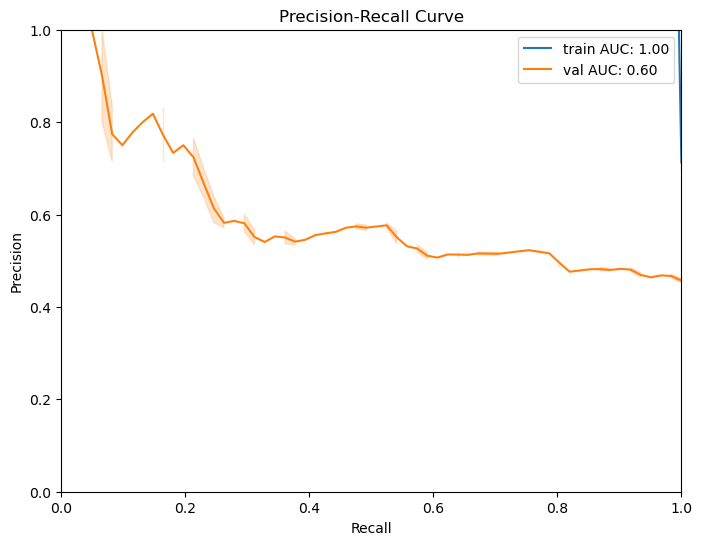

In [10]:
# train a model

train_X, train_y = next(iter(embedding_dataset.train_dataloader()))
val_X, val_y = next(iter(embedding_dataset.val_dataloader()))
test_X, test_y = next(iter(embedding_dataset.test_dataloader()))

dtrain = xgb.DMatrix(train_X, train_y)
dval = xgb.DMatrix(val_X, val_y)
dtest = xgb.DMatrix(test_X, test_y)

evals = [(dtrain, "train"), (dval, "eval")]

params = {
    "objective": "reg:logistic", 
    "eval_metric": "auc",
    "tree_method": "gpu_hist"
}
n = 100

model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    evals=evals,
    num_boost_round=n, 
    early_stopping_rounds=10
)

train_preds = (model.predict(dtrain, iteration_range=(0, model.best_iteration + 1)), train_y, "train")
val_preds = (model.predict(dval, iteration_range=(0, model.best_iteration + 1)), val_y, "val")

plot_pr_curves(train_preds, val_preds)

[0]	train-logloss:0.68822	eval-logloss:0.69838
[1]	train-logloss:0.68654	eval-logloss:0.69596
[2]	train-logloss:0.68572	eval-logloss:0.69490
[3]	train-logloss:0.68530	eval-logloss:0.69426
[4]	train-logloss:0.68508	eval-logloss:0.69389
[5]	train-logloss:0.68495	eval-logloss:0.69364
[6]	train-logloss:0.68487	eval-logloss:0.69345
[7]	train-logloss:0.68481	eval-logloss:0.69331
[8]	train-logloss:0.68477	eval-logloss:0.69321
[9]	train-logloss:0.68474	eval-logloss:0.69313
[10]	train-logloss:0.68472	eval-logloss:0.69305
[11]	train-logloss:0.68470	eval-logloss:0.69300
[12]	train-logloss:0.68468	eval-logloss:0.69294
[13]	train-logloss:0.68466	eval-logloss:0.69292
[14]	train-logloss:0.68465	eval-logloss:0.69289
[15]	train-logloss:0.68463	eval-logloss:0.69282
[16]	train-logloss:0.68461	eval-logloss:0.69281
[17]	train-logloss:0.68461	eval-logloss:0.69273
[18]	train-logloss:0.68460	eval-logloss:0.69271
[19]	train-logloss:0.68458	eval-logloss:0.69274
[20]	train-logloss:0.68458	eval-logloss:0.69266
[2

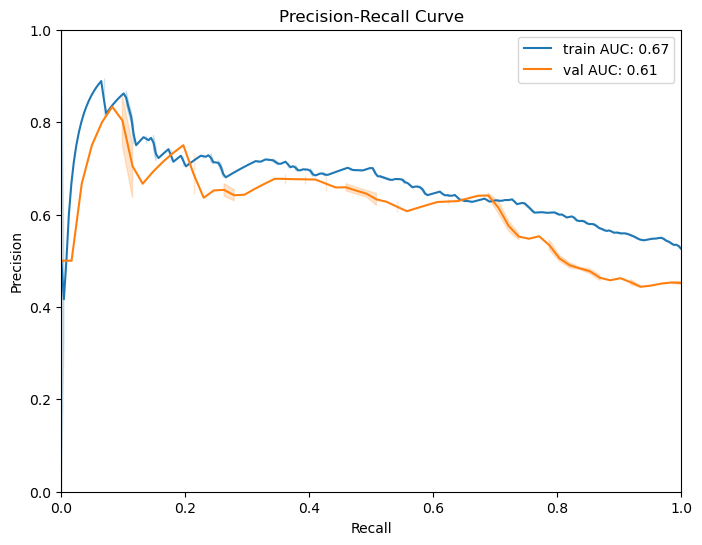

In [11]:
# train a model: gblinear booster

train_X, train_y = next(iter(embedding_dataset.train_dataloader()))
val_X, val_y = next(iter(embedding_dataset.val_dataloader()))
test_X, test_y = next(iter(embedding_dataset.test_dataloader()))

dtrain = xgb.DMatrix(train_X, train_y)
dval = xgb.DMatrix(val_X, val_y)
dtest = xgb.DMatrix(test_X, test_y)

evals = [(dtrain, "train"), (dval, "eval")]

params = {
    "objective": "binary:logistic", 
    "booster": "gblinear",
    "alpha": 0.0001, 
    "lambda": 1
}
n = 100

model = xgb.train(
    params=params, 
    dtrain=dtrain, 
    evals=evals,
    num_boost_round=n, 
    early_stopping_rounds=10
)

train_preds = (model.predict(dtrain, iteration_range=(0, model.best_iteration + 1)), train_y, "train")
val_preds = (model.predict(dval, iteration_range=(0, model.best_iteration + 1)), val_y, "val")

plot_pr_curves(train_preds, val_preds)

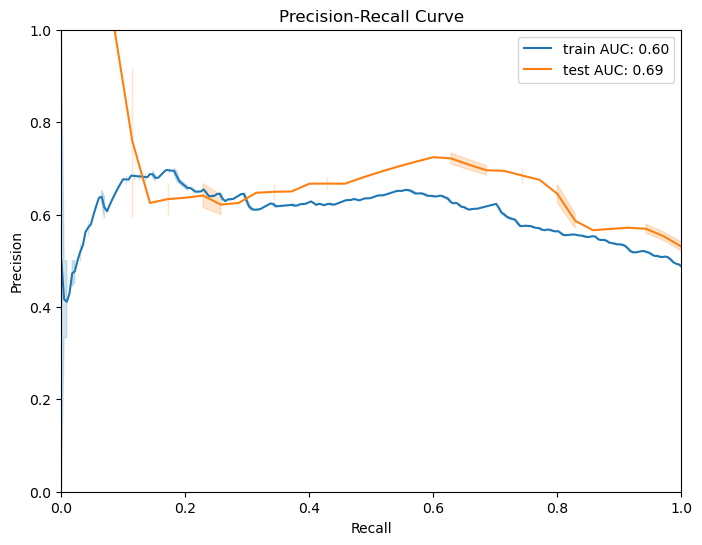

In [22]:
train_preds = (model.predict(dtrain, iteration_range=(0, model.best_iteration + 1)), train_y, "train")
test_preds = (model.predict(dtest, iteration_range=(0, model.best_iteration + 1)), test_y, "test")

plot_pr_curves(train_preds, test_preds)

In [100]:
model.best_iteration

28

In [82]:
def plot_pr_curves(*datasets, figsize=(8, 6), **kwargs):
    # Create a figure to plot the precision-recall curves
    plt.figure(figsize=(8, 6))
    
    for dataset in datasets:
        scores = dataset[0]
        labels = dataset[1]
        name = dataset[2]
        precision, recall, _ = precision_recall_curve(labels, scores)
        area = auc(recall, precision, )
        sns.lineplot(x=recall, y=precision, label=f"{name} AUC: {area:.2f}", **kwargs)
        
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
        
        
def plot_roc_curves(*datasets, figsize=(8, 6), **kwargs):
    # Create a figure to plot the precision-recall curves
    plt.figure(figsize=(8, 6))
    
    for dataset in datasets:
        scores = dataset[0]
        labels = dataset[1]
        name = dataset[2]
        fpr, tpr, _ = roc_curve(labels, scores)
        area = auc(fpr, tpr)
        sns.lineplot(x=fpr, y=tpr, label=f"{name} AUC: {area:.2f}", **kwargs)   
        
    plt.title("ROC-Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()

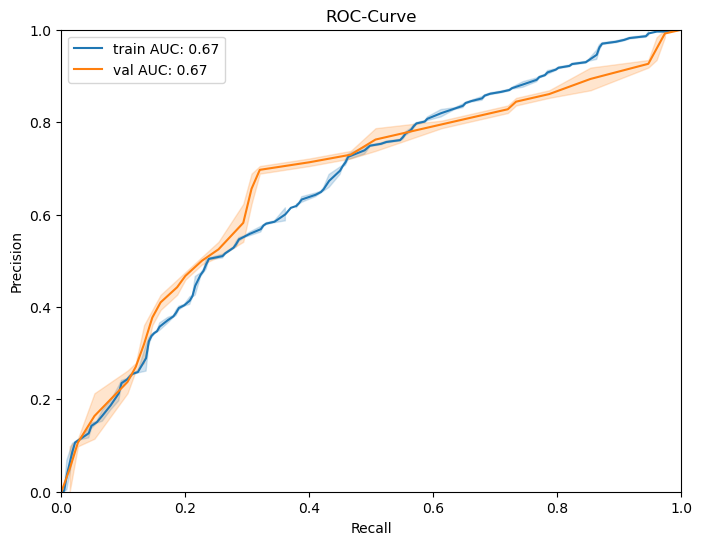

In [12]:
plot_roc_curves(train_preds, val_preds)

In [22]:
# train set
train_pred_scores = model.predict(dtrain)
train_sensitivity, train_specificity, train_auc_t = roc_curve(train_y, train_pred_scores)
train_precision, train_recall, train_pr_t = precision_recall_curve(train_y, train_pred_scores)


# test set
test_pred_scores = model.predict(dtest)
test_sensitivity, test_specificity, test_auc_t = roc_curve(test_y, test_pred_scores)
test_precision, test_recall, test_pr_t = precision_recall_curve(test_y, test_pred_scores)

In [28]:
train_pred_scores

array([9.97840524e-01, 8.69162788e-04, 9.76826727e-01, 9.91057873e-01,
       9.82333660e-01, 9.93040800e-01, 1.23367393e-02, 1.13739753e-02,
       7.58807361e-03, 9.86842930e-01, 7.30647705e-03, 1.18082007e-02,
       9.89648048e-03, 9.99177516e-01, 9.88560736e-01, 9.83443260e-01,
       5.11177629e-03, 9.85208750e-01, 9.88721848e-01, 9.78015363e-01,
       5.70843183e-03, 9.95404243e-01, 9.97289777e-01, 1.69521347e-02,
       9.94407773e-01, 9.82552648e-01, 9.97253358e-01, 9.96028185e-01,
       9.49617568e-03, 9.84966815e-01, 1.12853702e-02, 9.95898783e-01,
       9.89977717e-01, 1.13651054e-02, 1.68361422e-02, 9.91502047e-01,
       1.20142931e-02, 1.46212045e-03, 9.93772566e-01, 8.36718082e-03,
       9.83615458e-01, 1.18706422e-02, 5.00718318e-03, 6.47570053e-03,
       5.24927396e-03, 9.89522755e-01, 9.86876011e-01, 2.99017667e-03,
       9.95179772e-01, 1.09873461e-02, 9.82097805e-01, 9.70927298e-01,
       9.89099681e-01, 9.95744050e-01, 1.39652006e-02, 9.96483684e-01,
      

<Axes: >

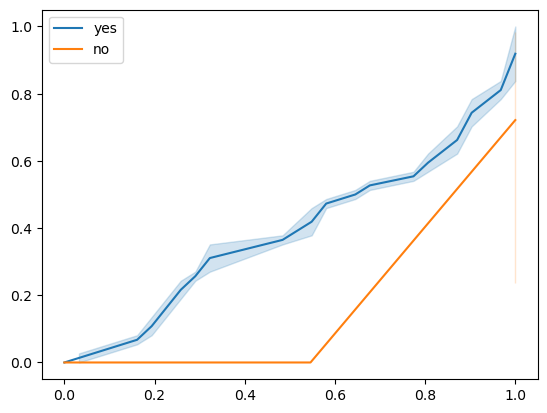

In [32]:
fig = plt.figur
sns.lineplot(x=test_specificity, y=test_sensitivity, label="yes")
sns.lineplot(x=train_specificity, y=train_sensitivity, label="no")

<Axes: >

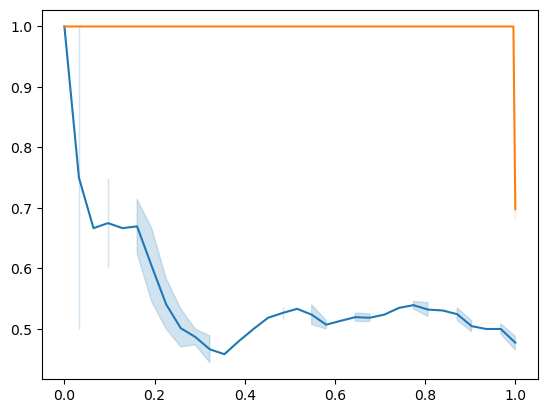

In [25]:
sns.lineplot(x=test_recall, y=test_precision)
sns.lineplot(x=train_recall, y=train_precision)

In [ ]:
mode